In [166]:
# load mnist dataset using torch
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)

mnist_trainset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train

## Schritte 

* Dataset bauen
* Modell bauen
* Loss-Funktion, Optimizer
* Trainingsschleife

x.shape: torch.Size([784])
y: tensor(5)


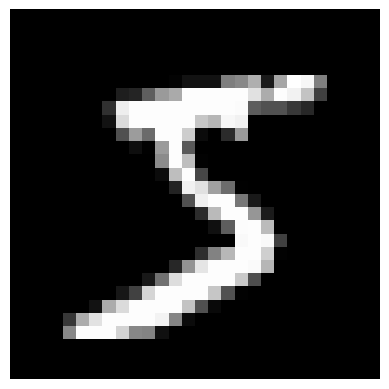

In [167]:
import torch

class MyDataset(torch.utils.data.Dataset):
    def __init__(self, ds):
        self.ds=ds  

    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, idx):
        # self.ds ist ein Dataset besteht aus Tupeln (x, y) wobei x jeweils ein PIL-Image ist
        x, y=self.ds[idx]
        y=torch.tensor(y)


        # get values of pil image x
        x=torch.tensor(list(x.getdata()), dtype=torch.float32)
        x=x/255.0-0.5

        # Ziel: x: als Tensor mit 784 Elementen, y: als Tensor mit 1 Element
        return x, y
    
dataset_sample=MyDataset(mnist_trainset)
x, y=dataset_sample[0]
print("x.shape:", x.shape)          # torch.Size([784])
print("y:", y)                      # tensor(5)

image=x.reshape(28, 28)
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()

In [168]:
class MnistModel(torch.nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.lin1=torch.nn.Linear(784, hidden_size)
        self.lin2=torch.nn.Linear(hidden_size, 10)
        self.batch_norm=torch.nn.BatchNorm1d(hidden_size)
        self.relu=torch.nn.ReLU()
        self.softmax=torch.nn.Softmax(dim=1)
        
    def forward(self, x):
        x=self.lin1(x)
        x=self.relu(x)
        x=self.batch_norm(x)
        x=self.lin2(x)
        return x
    
model=MnistModel(100)
dataset_sample=MyDataset(mnist_trainset)
loader=torch.utils.data.DataLoader(dataset_sample, batch_size=4, shuffle=True)
xb, yb=next(iter(loader))

model(xb).shape

torch.Size([4, 10])

In [169]:
from sklearn.model_selection import train_test_split
train_ds, valid_ds = train_test_split(mnist_trainset, test_size=0.2, random_state=42, stratify=mnist_trainset.targets)

In [170]:
train_dataset=MyDataset(train_ds)
valid_dataset=MyDataset(valid_ds)


  0%|          | 0/50 [00:00<?, ?it/s]

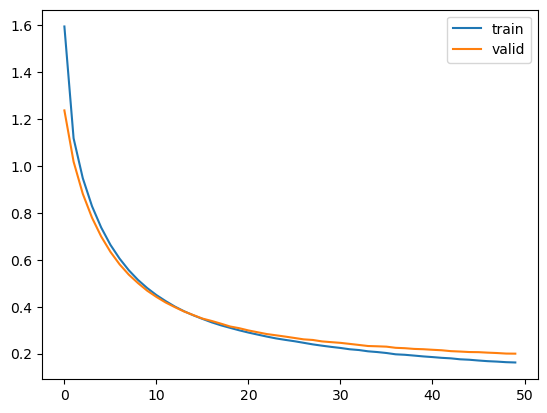

In [171]:
lr=0.0001
batch_size=256
epochs=50
hidden_size=20


model=MnistModel(hidden_size)
optimizer=torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.0001)
loss_func=torch.nn.CrossEntropyLoss()

train_loader=torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader=torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

losses=[]
valid_losses=[]

bar=tqdm(range(epochs))
for i in bar:
    epoch_losses=[]
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred=model(xb)
        loss=loss_func(pred, yb)
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
    losses.append(sum(epoch_losses)/len(epoch_losses))
    valid_losses_epoch=[]
    with torch.no_grad():
        for xb, yb in valid_loader:
            pred=model(xb)
            loss=loss_func(pred, yb)
            valid_losses_epoch.append(loss.item())
    valid_losses.append(sum(valid_losses_epoch)/len(valid_losses_epoch))
    bar.set_postfix({'train_loss': losses[-1], 'valid_loss': valid_losses[-1]})

plt.plot(losses, label='train')
plt.plot(valid_losses, label='valid')
plt.legend()
plt.show()

In [172]:
correct = 0
total = 0

with torch.no_grad():
    for xb, yb in valid_loader:
        pred = model(xb)
        _, predicted = torch.max(pred.data, 1)
        total += yb.size(0)
        correct += (predicted == yb).sum().item()

accuracy = correct / total
print("Accuracy:", accuracy)


Accuracy: 0.942
